In [1]:
# Install necessary packages
!pip install numpy matplotlib scipy ipywidgets opencv-python ipympl


[notice] A new release of pip is available: 23.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector

# Function to downsample frames by a given factor
def downsample_frames(movie_data, factor):
    # Downsample each frame by the given factor
    downsampled_data = movie_data[:, ::factor, ::factor]
    return downsampled_data

# Function to process data in batches
def process_in_batches(data, batch_size, func, *args):
    results = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        result = func(batch, *args)
        results.append(result)
    return np.concatenate(results)

# Load data efficiently using memory mapping and a lower data type
movie_data = np.load('C:/Users/pilla/Downloads/movie.npy', mmap_mode='r').astype(np.float32)
time_data = np.load('C:/Users/pilla/Downloads/time.npy', mmap_mode='r').astype(np.float32)

# Increase the downsampling factor (e.g., 8 means reducing the resolution by an eighth)
downsampling_factor = 8

# Downsample the movie data in batches
batch_size = 100  # Adjust batch size as needed
downsampled_movie_data = process_in_batches(movie_data, batch_size, downsample_frames, downsampling_factor)

# Save the downsampled data to a new file (optional)
np.save('C:/Users/pilla/Downloads/downsampled_movie.npy', downsampled_movie_data)

print(f"Original Movie Data Shape: {movie_data.shape}")
print(f"Downsampled Movie Data Shape: {downsampled_movie_data.shape}")


Original Movie Data Shape: (2593, 922, 1384)
Downsampled Movie Data Shape: (2593, 116, 173)


In [6]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Display the first frame initially
fig, ax = plt.subplots()
img_display = ax.imshow(movie_data[0], cmap='gray', interpolation='nearest')  # Display the first frame
fig.canvas.draw_idle()

# Setting up the slider
slider_ax = plt.axes([0.25, 0.01, 0.5, 0.03])  # Slider position
slider = Slider(slider_ax, 'Frame', 0, movie_data.shape[0]-1, valinit=0, valstep=1)

# Optimized update function for the slider
def update(val):
    frame = int(slider.val)
    img_display.set_data(movie_data[frame])  # Update the frame
    fig.canvas.blit(ax.bbox)  # Use blitting for faster updates

slider.on_changed(update)
plt.show()


Displaying initial frame...


C:\Users\pilla\AppData\Local\Temp\ipykernel_800\3581845366.py:22: MatplotlibDeprecationWarning: The 'drawtype' parameter of __init__() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'drawtype', they should be passed as keyword, not positionally.
  rect_selector = RectangleSelector(


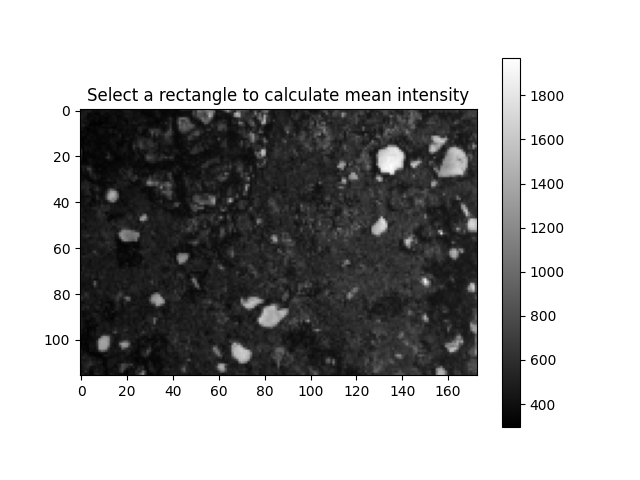

In [5]:
# Global variable for rectangle coordinates
rect_coords = None

# Function to handle rectangle selection and trigger intensity calculation
def on_select(eclick, erelease):
    global rect_coords
    rect_coords = (
        int(eclick.xdata), int(eclick.ydata),
        int(erelease.xdata), int(erelease.ydata)
    )
    print(f"Rectangle coordinates: {rect_coords}")
    plot_relative_intensity()  # Call this function after selection

# Initialize plot and show the first frame
print("Displaying initial frame...")
fig, ax = plt.subplots()
img_display = ax.imshow(downsampled_movie_data[0], cmap='gray')
plt.colorbar(img_display, ax=ax)
ax.set_title("Select a rectangle to calculate mean intensity")

# Rectangle selector for interactive selection
rect_selector = RectangleSelector(
    ax, on_select, drawtype='box', useblit=True,
    button=[1], interactive=True,
)

# Function to calculate and plot relative intensity
def plot_relative_intensity():
    if rect_coords is None:
        print("No rectangle selected. Please select a rectangle on the image.")
        return
    
    # Extract coordinates and calculate mean intensity in batches
    x1, y1, x2, y2 = rect_coords
    print(f"Calculating mean intensity for coordinates: {rect_coords}")
    
    def calculate_mean_intensity(batch):
        return np.mean(batch[:, y1:y2, x1:x2], axis=(1, 2))
    
    mean_intensity = process_in_batches(downsampled_movie_data, batch_size, calculate_mean_intensity)
    print(f"Mean intensity calculated: {mean_intensity[:5]}...")  # Print first 5 values for debugging
    
    # Normalize by the first value in the series
    relative_intensity = mean_intensity / mean_intensity[0]
    print(f"Relative intensity calculated: {relative_intensity[:5]}...")  # Print first 5 values for debugging
    
    # Plot relative intensity over time
    plt.figure()
    plt.plot(time_data, relative_intensity, label='Relative Intensity')
    plt.xlabel("Time (s)")
    plt.ylabel("Relative Intensity")
    plt.title("Relative Intensity inside Selected Rectangle over Time")
    plt.legend()
    plt.show()

plt.show()
